In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [4]:
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ'])]
df_iron_gb = df_iron[df_iron['Type'].isin(['GBRZ'])]

In [5]:
# Group by 'code' and calculate the mean while ignoring NaN values
grouped_df = df_meta.groupby('Station')[['Lat', 'Lon']].mean(numeric_only=True)

# Reset the index to make it a table
grouped_df.reset_index(inplace=True)
df_met = grouped_df

In [6]:
df_mobile_mud = pd.read_csv('../Dissertation_projects/Data/mobile_muds.csv', sep=',', index_col=0)

In [7]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

df_p = df_por.groupby('code').agg({
    'Stn': 'first',
    'camp': 'first'
}).reset_index()

df_p.index = df_p['code']

In [8]:
# Group by 'code' and calculate the mean while ignoring NaN values
grouped_df = df_meta.groupby('code')[['Lat', 'Lon']].mean(numeric_only=True)

# Reset the index to make it a table
grouped_df.reset_index(inplace=True)
grouped_df.index = grouped_df['code']
df_met = grouped_df.drop('code', axis = 1)

In [9]:
# Use combine_first to create 'Depth' column
df_iron_pw['Depth'] = df_iron_pw["Fe2_Depth"].combine_first(df_iron_pw["FeT_Depth"])
df_iron_pw['Date'] = df_iron_pw["Fe2_Date"].combine_first(df_iron_pw["FeT_Date"])

df_iron_vol = df_iron_pw.drop(columns=["Fe2_Depth","FeT_Depth","Fe2_Date","FeT_Date","Fe2_Time","FeT_Time"])
df_iron_vol['Sample_ID'] = df_iron_vol.index

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\1342446597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iron_pw['Depth'] = df_iron_pw["Fe2_Depth"].combine_first(df_iron_pw["FeT_Depth"])
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\1342446597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iron_pw['Date'] = df_iron_pw["Fe2_Date"].combine_first(df_iron_pw["FeT_Date"])


In [10]:
#Remove all rows with Depth values less than 0, more then 5 or NaN
df_iron_vol["Depth"] = pd.to_numeric(df_iron_vol["Depth"], errors='coerce')
df_iron_vol = df_iron_vol[df_iron_vol["Depth"].notna() & (df_iron_vol["Depth"] >= 0)]

cols_to_correct = ["Fe2_uM", "FeT_uM", "Fe3_uM"]
for col in cols_to_correct:
    df_iron_vol.loc[df_iron_vol[col] < 0, col] = np.nan


def compute_depth_span(group):
    sorted_group = group.sort_values(by="Depth")
    depths = [0] + sorted_group["Depth"].tolist() + [40]
    
    spans = [depths[i+1] - depths[i] for i in range(len(depths)-1)]
    
    # Create a Depth_span array and fill it with computed values (excluding the first span)
    depth_span_array = np.array(spans[1:])
    sorted_group['Depth_span'] = depth_span_array
    
    return sorted_group

# Applying the function to the DataFrame
df_iron_vol = df_iron_vol.groupby("code").apply(compute_depth_span).reset_index(drop=True)



# Convert the 'Depth' column to numeric
df_iron_vol["Depth"] = pd.to_numeric(df_iron_vol["Depth"], errors='coerce')

#Remove all rows with Depth values less than 0 or NaN
df_iron_vol = df_iron_vol[df_iron_vol["Depth"].notna() & (df_iron_vol["Depth"] >= 0)]

def interpolate_porosity_for_code(code):
    # Extracting relevant rows
    subset_por = df_por[df_por['code'] == code]
    subset_vol = df_iron_vol[df_iron_vol['code'] == code]
    
    # Check if subset is empty
    if subset_por.empty:
        return pd.Series(np.nan, index=subset_vol.index)

    # Interpolating porosity values to match df_iron_vol's Depth values
    interpolated_porosity = np.interp(subset_vol['Depth'], subset_por['depth'], subset_por['porosity'])

    return pd.Series(interpolated_porosity, index=subset_vol.index)

# Apply the function for each 'code' and get the interpolated porosities series
interpolated_porosities = df_iron_vol.groupby('code').apply(lambda group: interpolate_porosity_for_code(group['code'].iloc[0])).reset_index(level=0, drop=True)

# Assign the series to the df_iron_vol DataFrame
df_iron_vol['porosity'] = interpolated_porosities

df_iron_vol

,Treatment,Campaign,Location,Type,FeT_uM,FeT_mgL,FeT_Notes,Fe2_uM,Fe2_mgL,Fe2_Notes,Fe3_uM,code,Depth,Date,Sample_ID,Depth_span,porosity
0,P2F,GOM2021,St.11,PW,NaN,NaN,St.11 1,0.145,NaN,St.11 1,NaN,St.11_GOM2021,0.35,7/25/2021,212801,0.7,0.897196
1,P2F,GOM2021,St.11,PW,NaN,NaN,St.11 2,NaN,NaN,St.11 2,NaN,St.11_GOM2021,1.05,7/25/2021,212802,0.7,0.891846
2,P2F,GOM2021,St.11,PW,NaN,NaN,St.11 3,0.145,NaN,St.11 3,NaN,St.11_GOM2021,1.75,7/25/2021,212803,0.7,0.879845
3,P2F,GOM2021,St.11,PW,NaN,NaN,St.11 4,0.145,NaN,St.11 4,NaN,St.11_GOM2021,2.45,7/25/2021,212804,0.7,0.870578
4,P2F,GOM2021,St.11,PW,NaN,NaN,St.11 5,0.145,NaN,St.11 5,NaN,St.11_GOM2021,3.15,7/25/2021,212805,0.7,0.864441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,P2F,GOM22SU,St.MK,PW,9.989839,0.557882583,NaN,0.699,0.039,Left out og glove bag,9.290839,St.MK_GOM22SU,22.20,7/24/2022,225319,2.5,0.704056
969,P2F,GOM22SU,St.MK,PW,9.463629,0.528496371,NaN,0.677,0.038,Left out og glove bag,8.786629,St.MK_GOM22SU,24.70,7/24/2022,225320,3.0,0.659089
970,P2F,GOM22SU,St.MK,PW,NaN,NaN,NaN,1.032,0.058,Left out og glove bag,NaN,St.MK_GOM22SU,27.70,7/24/2022,225321,3.0,0.605461
971,P2F,GOM22SU,St.MK,PW,3.849622,0.214982127,NaN,NaN,NaN,NaN,NaN,St.MK_GOM22SU,30.70,7/23/2022,225322,3.0,0.673309


In [11]:
#Remove all rows with Depth values less than 0, more then 5 or NaN
df_iron_vol_5cm = df_iron_vol[(df_iron_vol["Depth"] < 5)]
print(len(df_iron_vol_5cm))
df_por_5cm = df_por[df_por["depth"].notna() & (df_por["depth"]) >= 0 & (df_por["depth"] < 5)]


def compute_depth_span(group):
    sorted_group = group.sort_values(by="Depth")
    depths = [0] + sorted_group["Depth"].tolist() + [5]
    
    spans = [depths[i+1] - depths[i] for i in range(len(depths)-1)]
    
    # Create a Depth_span array and fill it with computed values (excluding the first span)
    depth_span_array = np.array(spans[1:])
    sorted_group['Depth_span'] = depth_span_array
    
    return sorted_group

# Applying the function to the DataFrame
df_iron_vol_5cm = df_iron_vol_5cm.groupby("code").apply(compute_depth_span).reset_index(drop=True)

# Convert the 'Depth' column to numeric
df_iron_vol_5cm["Depth"] = pd.to_numeric(df_iron_vol_5cm["Depth"], errors='coerce')

#Remove all rows with Depth values less than 0 or NaN
df_iron_vol_5cm = df_iron_vol_5cm[df_iron_vol_5cm["Depth"].notna() & (df_iron_vol_5cm["Depth"] >= 0)]

def interpolate_porosity_for_code(code):
    # Extracting relevant rows
    subset_por = df_por_5cm[df_por_5cm['code'] == code]
    subset_vol = df_iron_vol_5cm[df_iron_vol_5cm['code'] == code]
    
    # Check if subset is empty
    if subset_por.empty:
        return pd.Series(np.nan, index=subset_vol.index)

    # Interpolating porosity values to match df_iron_vol's Depth values
    interpolated_porosity = np.interp(subset_vol['Depth'], subset_por['depth'], subset_por['porosity'])

    return pd.Series(interpolated_porosity, index=subset_vol.index)

# Apply the function for each 'code' and get the interpolated porosities series
interpolated_porosities = df_iron_vol_5cm.groupby('code').apply(lambda group: interpolate_porosity_for_code(group['code'].iloc[0])).reset_index(level=0, drop=True)

# Assign the series to the df_iron_vol DataFrame
df_iron_vol_5cm['porosity'] = interpolated_porosities

df_iron_vol_5cm

317


,Treatment,Campaign,Location,Type,FeT_uM,FeT_mgL,FeT_Notes,Fe2_uM,Fe2_mgL,Fe2_Notes,Fe3_uM,code,Depth,Date,Sample_ID,Depth_span,porosity
0,P2F,GOM2021,St.11,PW,NaN,NaN,St.11 1,0.145,NaN,St.11 1,NaN,St.11_GOM2021,0.35,7/25/2021,212801,0.70,0.897196
1,P2F,GOM2021,St.11,PW,NaN,NaN,St.11 2,NaN,NaN,St.11 2,NaN,St.11_GOM2021,1.05,7/25/2021,212802,0.70,0.891846
2,P2F,GOM2021,St.11,PW,NaN,NaN,St.11 3,0.145,NaN,St.11 3,NaN,St.11_GOM2021,1.75,7/25/2021,212803,0.70,0.879845
3,P2F,GOM2021,St.11,PW,NaN,NaN,St.11 4,0.145,NaN,St.11 4,NaN,St.11_GOM2021,2.45,7/25/2021,212804,0.70,0.870578
4,P2F,GOM2021,St.11,PW,NaN,NaN,St.11 5,0.145,NaN,St.11 5,NaN,St.11_GOM2021,3.15,7/25/2021,212805,0.70,0.864441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,P2F,GOM22SU,St.MK,PW,81.193795,4.534267493,NaN,1.300,0.073,Left out og glove bag,79.893795,St.MK_GOM22SU,1.75,7/24/2022,225303,0.70,0.815836
313,P2F,GOM22SU,St.MK,PW,99.257461,5.543032901,NaN,1.347,0.075,Left out og glove bag,97.910461,St.MK_GOM22SU,2.45,7/24/2022,225304,0.70,0.806177
314,P2F,GOM22SU,St.MK,PW,114.978738,6.42098762,NaN,1.689,0.094,Left out og glove bag,113.289738,St.MK_GOM22SU,3.15,7/24/2022,225305,0.70,0.787635
315,P2F,GOM22SU,St.MK,PW,104.048802,5.810605341,NaN,1.448,0.081,Left out og glove bag,102.600802,St.MK_GOM22SU,3.85,7/24/2022,225306,0.85,0.758396


In [12]:
df_iron_vol['Fe2'] = df_iron_vol['Fe2_uM'] * df_iron_vol['Depth_span']/100 * df_iron_vol['porosity']
df_iron_vol['Fe3'] = df_iron_vol['Fe3_uM'] * df_iron_vol['Depth_span']/100 * df_iron_vol['porosity']
df_iron_vol['FeT'] = df_iron_vol['FeT_uM'] * df_iron_vol['Depth_span']/100 * df_iron_vol['porosity']

# Group by 'code' and calculate the mean while ignoring NaN values
df_iron_vol_fe2 = df_iron_vol[df_iron_vol["Fe2"].notna()]
Fe2_groups_df = df_iron_vol_fe2.groupby('code')[['Fe2','Depth_span']].sum(numeric_only=True)
Fe2_groups_df['Fe2/m3'] = Fe2_groups_df['Fe2'] / (Fe2_groups_df['Depth_span']/100)


df_iron_vol_fe3 = df_iron_vol[df_iron_vol["Fe3"].notna()]
Fe3_groups_df = df_iron_vol_fe3.groupby('code')[['Fe3','Depth_span']].sum(numeric_only=True)
Fe3_groups_df['Fe3/m3'] = Fe3_groups_df['Fe3'] / (Fe3_groups_df['Depth_span']/100)


df_iron_vol_fet = df_iron_vol[df_iron_vol["FeT"].notna()]
FeT_groups_df = df_iron_vol_fet.groupby('code')[['FeT','Depth_span']].sum(numeric_only=True)
FeT_groups_df['FeT/m3'] = FeT_groups_df['FeT'] / (FeT_groups_df['Depth_span']/100)

df_iron_vol_5cm['Fe2'] = df_iron_vol_5cm['Fe2_uM'] * df_iron_vol_5cm['Depth_span']/100 * df_iron_vol_5cm['porosity']
df_iron_vol_5cm['Fe3'] = df_iron_vol_5cm['Fe3_uM'] * df_iron_vol_5cm['Depth_span']/100 * df_iron_vol_5cm['porosity']
df_iron_vol_5cm['FeT'] = df_iron_vol_5cm['FeT_uM'] * df_iron_vol_5cm['Depth_span']/100 * df_iron_vol_5cm['porosity']

# Group by 'code' and calculate the mean while ignoring NaN values
df_iron_vol_fe2_5cm = df_iron_vol_5cm[df_iron_vol_5cm["Fe2"].notna()]
Fe2_groups_df_5cm = df_iron_vol_fe2_5cm.groupby('code')[['Fe2','Depth_span']].sum(numeric_only=True)
Fe2_groups_df_5cm['Fe2/m3'] = Fe2_groups_df_5cm['Fe2'] / (Fe2_groups_df_5cm['Depth_span']/100)


df_iron_vol_fe3_5cm = df_iron_vol_5cm[df_iron_vol_5cm["Fe3"].notna()]
Fe3_groups_df_5cm = df_iron_vol_fe3_5cm.groupby('code')[['Fe3','Depth_span']].sum(numeric_only=True)
Fe3_groups_df_5cm['Fe3/m3'] = Fe3_groups_df_5cm['Fe3'] / (Fe3_groups_df_5cm['Depth_span']/100)


df_iron_vol_fet_5cm = df_iron_vol_5cm[df_iron_vol_5cm["FeT"].notna()]
FeT_groups_df_5cm = df_iron_vol_fet_5cm.groupby('code')[['FeT','Depth_span']].sum(numeric_only=True)
FeT_groups_df_5cm['FeT/m3'] = FeT_groups_df_5cm['FeT'] / (FeT_groups_df_5cm['Depth_span']/100)

In [13]:
#make the supper data set 

Fe2_groups = Fe2_groups_df.drop(['Depth_span', 'Fe2'], axis = 1)
Fe3_groups = Fe3_groups_df.drop(['Depth_span', 'Fe3'], axis = 1)
FeT_groups = FeT_groups_df.drop(['Depth_span', 'FeT'], axis = 1)

Fe2_groups5 = Fe2_groups_df_5cm.drop(['Depth_span', 'Fe2'], axis = 1)
Fe3_groups5 = Fe3_groups_df_5cm.drop(['Depth_span', 'Fe3'], axis = 1)
FeT_groups5 = FeT_groups_df_5cm.drop(['Depth_span', 'FeT'], axis = 1)

df_misk = df_p.drop(['code'], axis = 1)

map_data = df_misk.join([df_met, Fe2_groups, Fe3_groups, FeT_groups], how='outer')
map_data = map_data[map_data["Fe2/m3"].notna()]
map_data['Fe2:Fe3'] = map_data['Fe2/m3'] / map_data['Fe3/m3'] 
map_data['Fe3:Fe2'] = map_data['Fe3/m3'] / map_data['Fe2/m3'] 
map_data

,Stn,camp,Lat,Lon,Fe2/m3,Fe3/m3,FeT/m3,Fe2:Fe3,Fe3:Fe2
code,,,,,,,,,
St.11_GOM2021,St.11,GOM2021,28.225724,-89.540904,13.621269,73.543140,88.559761,0.185215,5.399140
St.11_GOM21FA,St.11,GOM21FA,28.209529,-89.591672,17.911562,63.876601,63.892666,0.280409,3.566222
St.11_GOM22SU,St.11,GOM22SU,28.202880,-89.581503,4.710410,36.075514,40.877340,0.130571,7.658678
St.12_GOM21FA,St.12,GOM21FA,28.594249,-88.903741,19.071937,100.450085,117.411579,0.189865,5.266905
St.12_GOM22SU,St.12,GOM22SU,28.593063,-88.878258,13.670384,34.718756,48.706858,0.393746,2.539706
St.13_GOM21FA,St.13,GOM21FA,28.524193,-89.610854,1.047507,61.778945,62.758282,0.016956,58.977099
St.13_GOM22SU,St.13,GOM22SU,28.524547,-89.597871,23.303065,42.947189,64.912783,0.542598,1.842985
St.14_GOM2021,St.14,GOM2021,28.726863,-89.601437,1.847952,24.403573,26.251526,0.075725,13.205737
St.14_GOM21FA,St.14,GOM21FA,28.727625,-89.620568,1.059759,26.098528,24.704344,0.040606,24.626853


In [14]:
map_data_5cm = df_misk.join([df_met, Fe2_groups5, Fe3_groups5, FeT_groups5], how='outer')
map_data_5cm = map_data_5cm[map_data_5cm["Fe2/m3"].notna()]
map_data_5cm['Fe2:Fe3'] = map_data_5cm['Fe2/m3'] / map_data_5cm['Fe3/m3'] 
map_data_5cm['Fe3:Fe2'] = map_data_5cm['Fe3/m3'] / map_data_5cm['Fe2/m3'] 
map_data_5cm

,Stn,camp,Lat,Lon,Fe2/m3,Fe3/m3,FeT/m3,Fe2:Fe3,Fe3:Fe2
code,,,,,,,,,
St.11_GOM2021,St.11,GOM2021,28.225724,-89.540904,0.126126,0.671360,0.792892,0.187866,5.322941
St.11_GOM22SU,St.11,GOM22SU,28.202880,-89.581503,0.125667,0.094160,0.127701,1.334616,0.749279
St.12_GOM21FA,St.12,GOM21FA,28.594249,-88.903741,0.330036,51.361957,33.792634,0.006426,155.625433
St.12_GOM22SU,St.12,GOM22SU,28.593063,-88.878258,0.488607,11.216431,11.705038,0.043562,22.955945
St.13_GOM21FA,St.13,GOM21FA,28.524193,-89.610854,0.057949,170.842347,170.901066,0.000339,2948.166141
St.13_GOM22SU,St.13,GOM22SU,28.524547,-89.597871,2.284174,7.668754,8.818789,0.297855,3.357342
St.14_GOM2021,St.14,GOM2021,28.726863,-89.601437,6.596523,37.756003,44.352527,0.174715,5.723622
St.14_GOM21FA,St.14,GOM21FA,28.727625,-89.620568,2.562950,54.327038,57.434561,0.047176,21.197070
St.14_GOM22SP,St.14,GOM22SP,28.726195,-89.613151,13.886978,14.991151,26.471490,0.926345,1.079511


In [15]:
lat_top=30
lat_bot=28
lon_left=-91.5
lon_rigth=-88.75
extent=[lon_left, lon_rigth, lat_bot, lat_top]

# set resolution of the features in map: '10m', '50m', or '110m'.  
# If you do this the first time it will take a while downloading the coastline 
# and other features. In the future it will be faster
res = '10m'

def plot_mapbase(extent, ax=None, res='10m', projection=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(10,5)) # set fig size
        ax = fig.add_subplot(111, projection=projection)
        
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', 
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue',
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

In [16]:
print(map_data['FeT/m3'].max())
print(map_data['Fe2/m3'].max())
print(map_data['Fe3/m3'].max())
print("")
print(map_data_5cm['FeT/m3'].max())
print(map_data_5cm['Fe2/m3'].max())
print(map_data_5cm['Fe3/m3'].max())

125.06917550942822
27.928661890104312
100.4500854454043

236.0614080878428
52.52964160155993
174.23005287313725


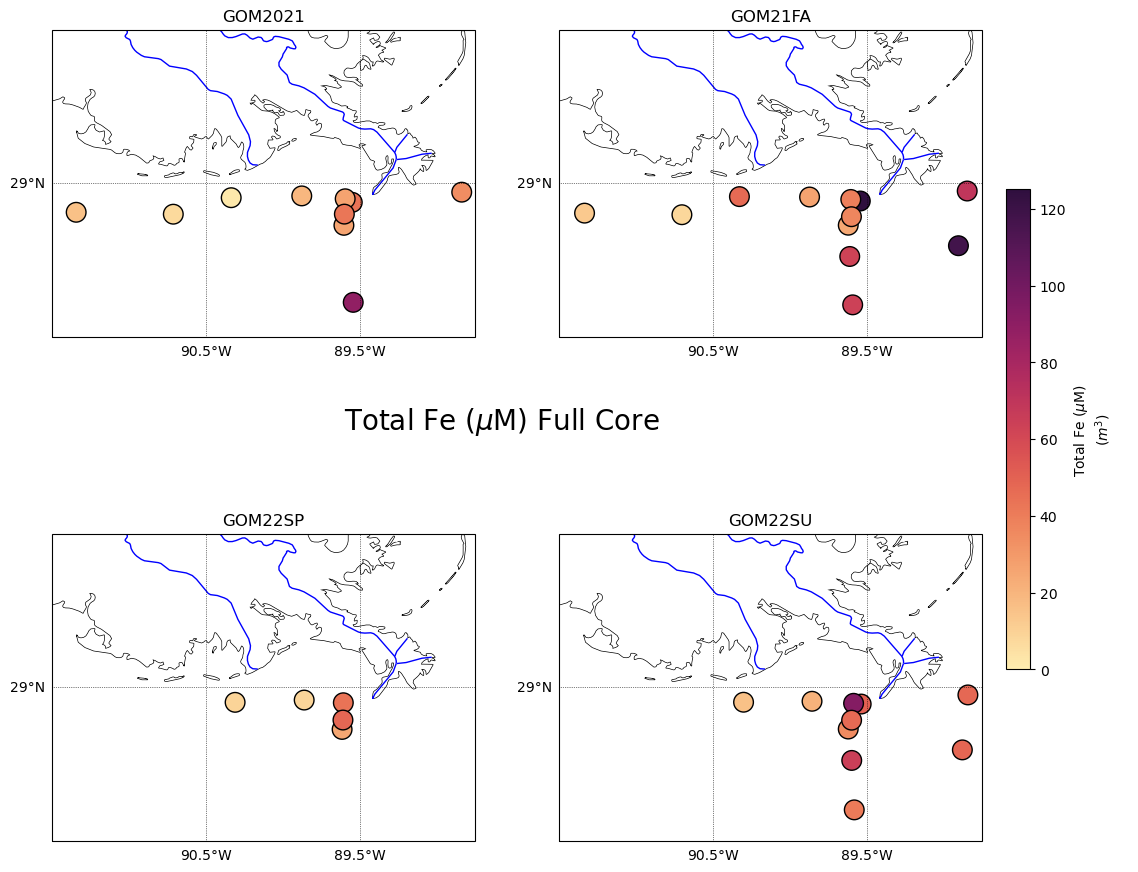

In [17]:
# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

#set params 
vmin = 0
vmax = map_data['FeT/m3'].max()
topic = "FeT/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Map_FeT_stocks.png"
cb_name = r'Total Fe ($\mu$M) '+'\n'+r'$(m^{3})$'+'\n'
text_fig = r'Total Fe ($\mu$M) Full Core'

def plot_fe_stocks(data_f, picks):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
    for i, camp in enumerate(camps):
        df_subset = data_f[data_f['camp'] == camp].dropna(subset=[topic])    
    
        # Plot the base map for each subplot
        plot_mapbase(extent, ax=axes[i])
    
        # Plotting
        mappable = axes[i].scatter(df_subset['Lon'], df_subset['Lat'],
                                   c=df_subset[topic],
                                   edgecolor='k',
                                   cmap=picks,
                                   s=200,
                                   vmin=vmin,  # Set global min and max for colormap
                                   vmax=vmax,
                                   transform=ccrs.PlateCarree())
    
        # Set title for each subplot
        axes[i].set_title(camp)
    
    # Add a single colorbar for the entire figure
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(cb_name, size=10, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)

    fig.set_facecolor('w')
    fig.text(0.5, 0.5, text_fig, size=20, ha='center')


    plt.savefig(plot_save)

    plt.show()
    
plot_fe_stocks(map_data, cmo.matter)

In [18]:
map_data['Stn'].unique()

array(['St.11', 'St.12', 'St.13', 'St.14', 'St.15', 'St.16', 'St.2',
       'St.4', 'St.5B', 'St.7', 'St.9', 'St.MK'], dtype=object)

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\2306357002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


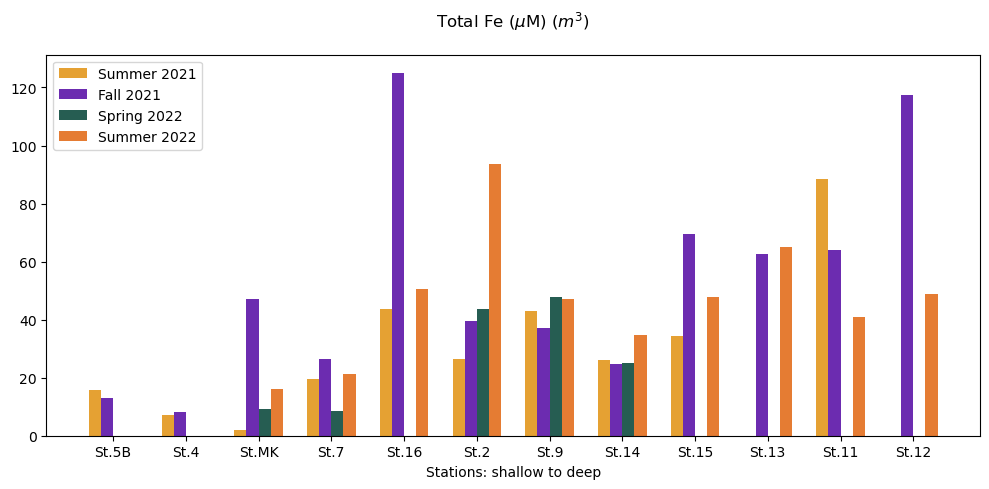

In [19]:
# Unique categories and subcategories
categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': '#E5A133',
    'GOM21FA': '#6C2CB0',
    'GOM22SP': '#265D52',
    'GOM22SU': '#E57C33'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

def bar_plot(data_f):
    # Create figure with custom size
    fig = plt.figure(figsize=(10, 5))

    # Adjusted r for spacing between groups
    r = np.arange(0, len(categories) * 1.5, 1.5)
    positions = [r + i*barWidth for i in range(len(subcategories))]

    # Adjusted code for bars
    for pos, subcat in zip(positions, subcategories):
        values = []
        for cat in categories:
            value = data_f[(data_f['Stn'] == cat) & (data_f['camp'] == subcat)][topic].values
            values.append(value[0] if len(value) > 0 else 0)
        
        ax = plt.subplot(1, 1, 1)
        ax.bar(pos, [v if v > 0 else 0 for v in values], width=barWidth, color=color_map[subcat], label=label_map[subcat])

    # Assuming you have a maximum value for y-axis in data_f[topic]
    max_value = data_f[topic].max()*1.05
    ax.set_ylim(0, max_value)  

    # Additional layout modifications
    ax.set_xlabel('Stations: shallow to deep')
    ax.set_title(title)
    #ax.set_xticks([r + barWidth for r in range(len(categories))])
    ax.set_xticklabels(categories)
    ax.set_xticks(r + 1.5*barWidth) 

    handles, _ = plt.gca().get_legend_handles_labels()
    labels = [label_map[subcat] for subcat in subcategories]
    ax.legend(handles[:len(subcategories)], labels)

    fig.set_facecolor('w')
    plt.tight_layout()

    plt.savefig(plot_save)
    plt.show()

topic = "FeT/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Bar_FeT_stocks.png"
title = r'Total Fe ($\mu$M) '+r'$(m^{3})$'+'\n'
    
bar_plot(map_data)

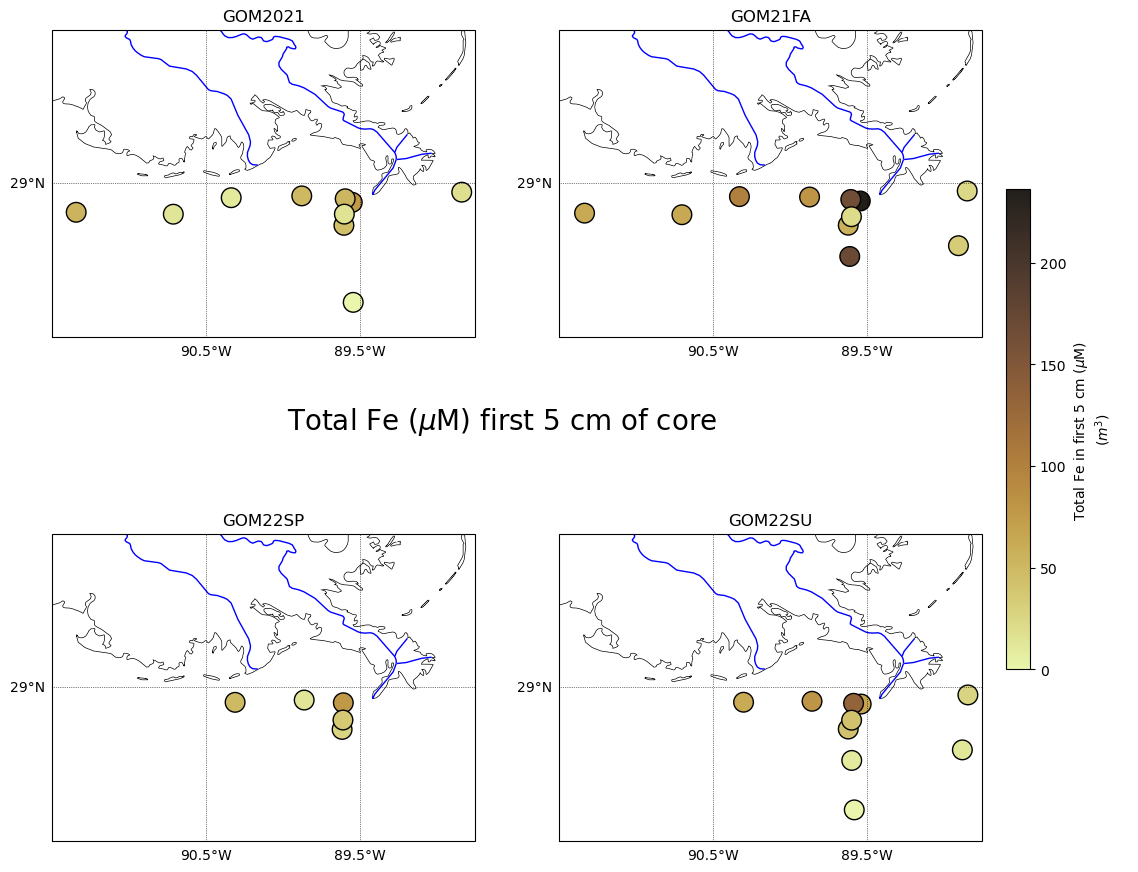

In [20]:
# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

#set params 
vmin = 0
vmax = map_data_5cm['FeT/m3'].max()
topic = "FeT/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Map_FeT_stocks_5cm.png"
cb_name = r'Total Fe in first 5 cm ($\mu$M) '+'\n'+r'$(m^{3})$'+'\n'
text_fig = r'Total Fe ($\mu$M) first 5 cm of core'


plot_fe_stocks(map_data_5cm, cmo.turbid)

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\2306357002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


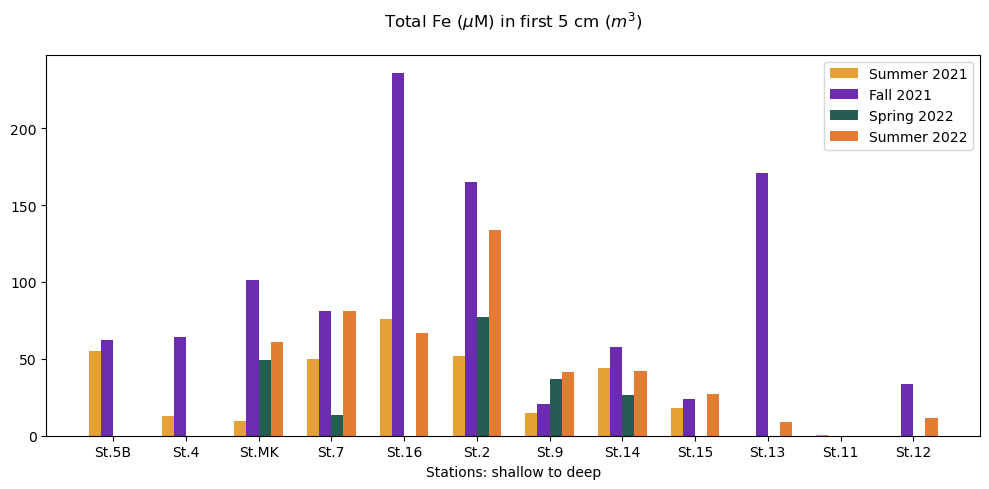

In [21]:
topic = "FeT/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Bar_FeT_stocks_5cm.png"
title = r'Total Fe ($\mu$M) in first 5 cm '+r'$(m^{3})$'+'\n'
bar_plot(map_data_5cm)

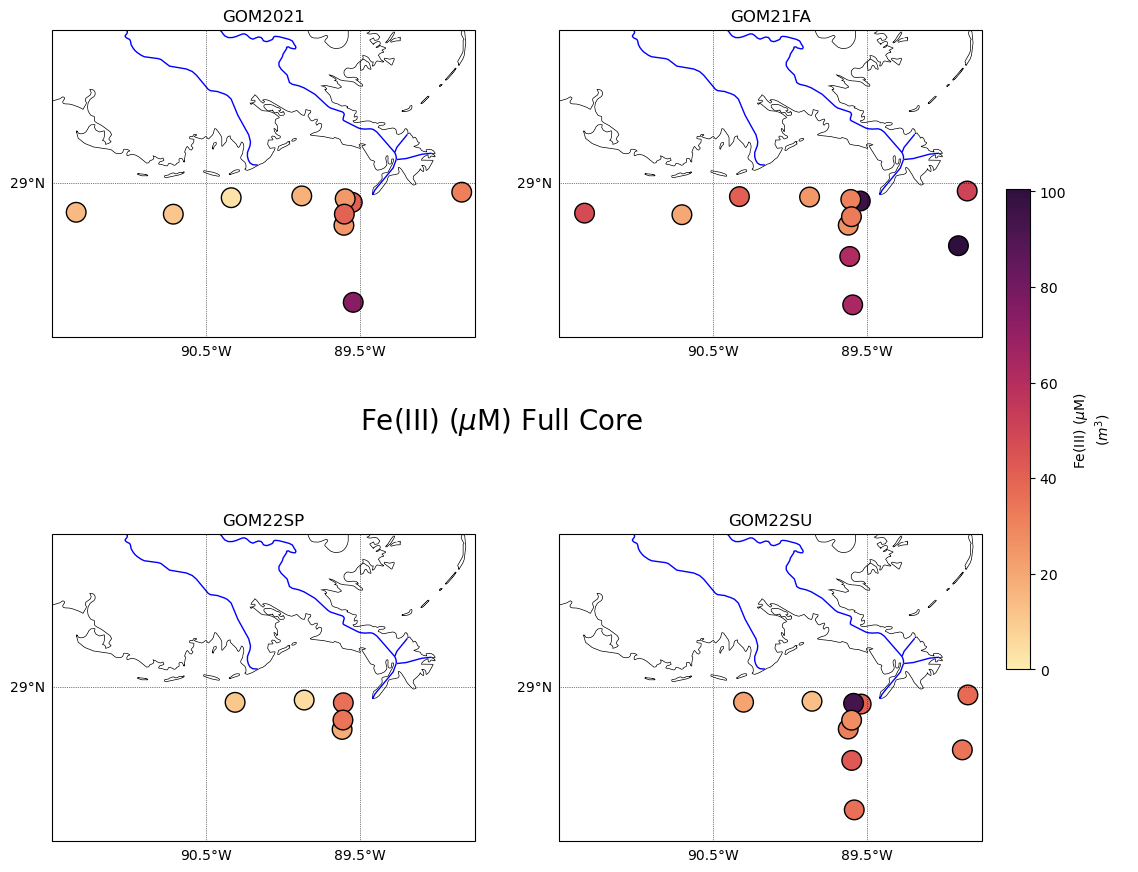

In [22]:
#set params 
vmin = 0
vmax = map_data['Fe3/m3'].max()
topic = "Fe3/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Map_Fe3_stocks.png"
cb_name = r'Fe(III) ($\mu$M) '+'\n'+r'$(m^{3})$'+'\n'
text_fig = r'Fe(III) ($\mu$M) Full Core'

plot_fe_stocks(map_data, cmo.matter)

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\2306357002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


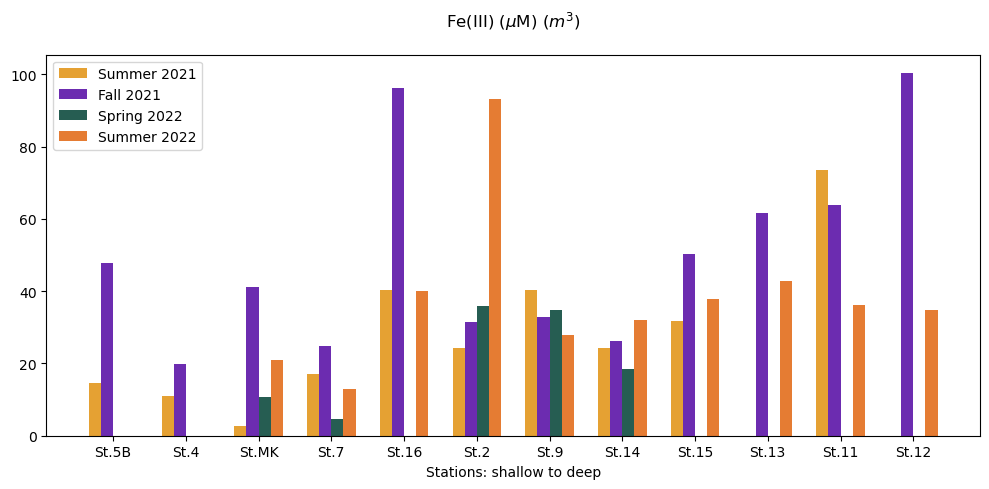

In [23]:
topic = "Fe3/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Bar_Fe3_stocks.png"
title = r'Fe(III) ($\mu$M) '+r'$(m^{3})$'+'\n'
bar_plot(map_data)

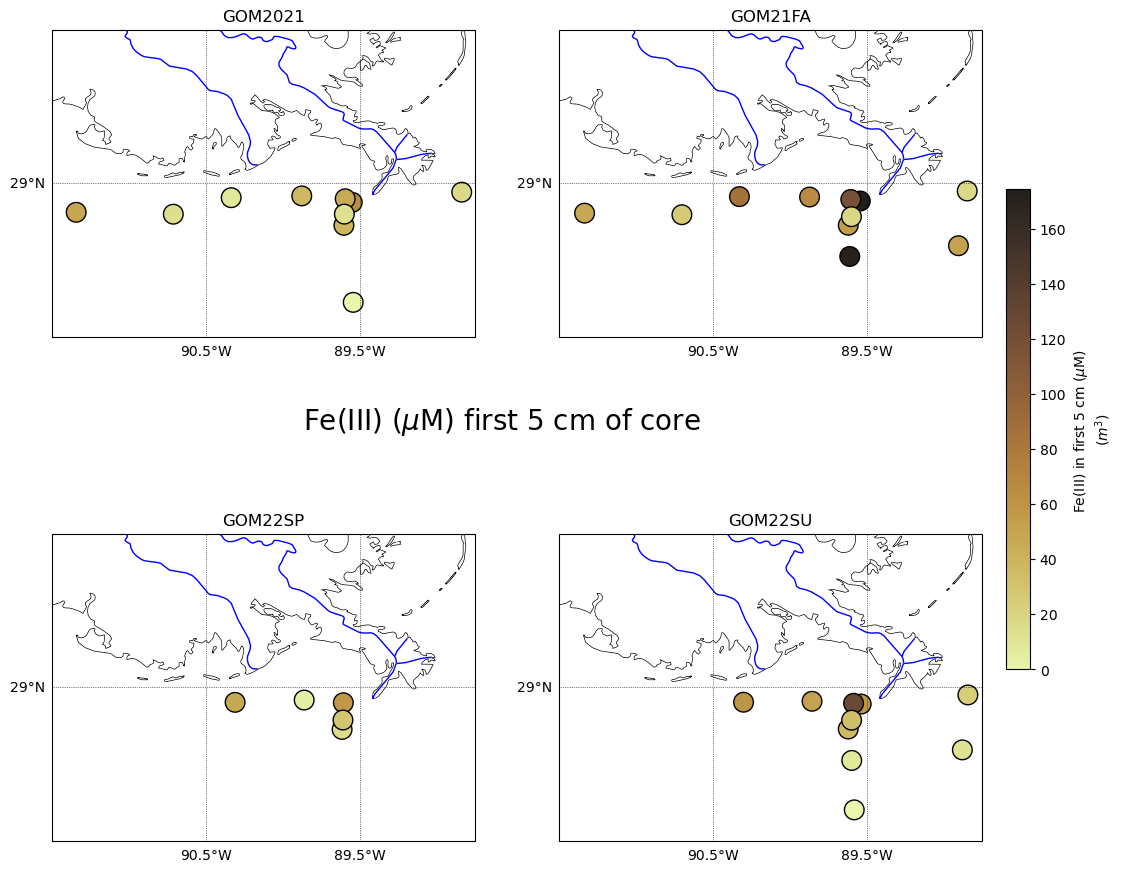

In [24]:
#set params 
vmin = 0
vmax = map_data_5cm['Fe3/m3'].max()
topic = "Fe3/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Map_Fe3_stocks_5cm.png"
cb_name = r'Fe(III) in first 5 cm ($\mu$M) '+'\n'+r'$(m^{3})$'+'\n'
text_fig = r'Fe(III) ($\mu$M) first 5 cm of core'


plot_fe_stocks(map_data_5cm, cmo.turbid)

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\2306357002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


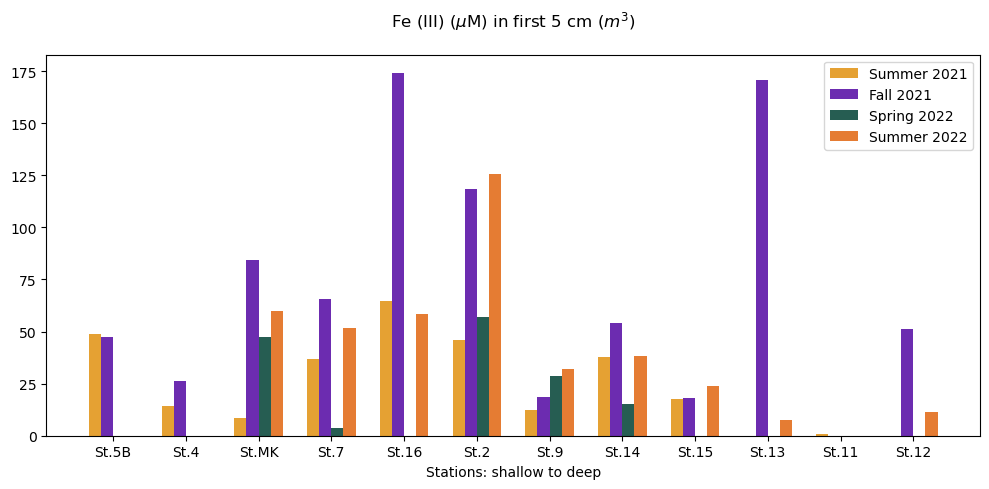

In [25]:
topic = "Fe3/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Bar_Fe3_stocks_5cm.png"
title = r'Fe (III) ($\mu$M) in first 5 cm '+r'$(m^{3})$'+'\n'
bar_plot(map_data_5cm)

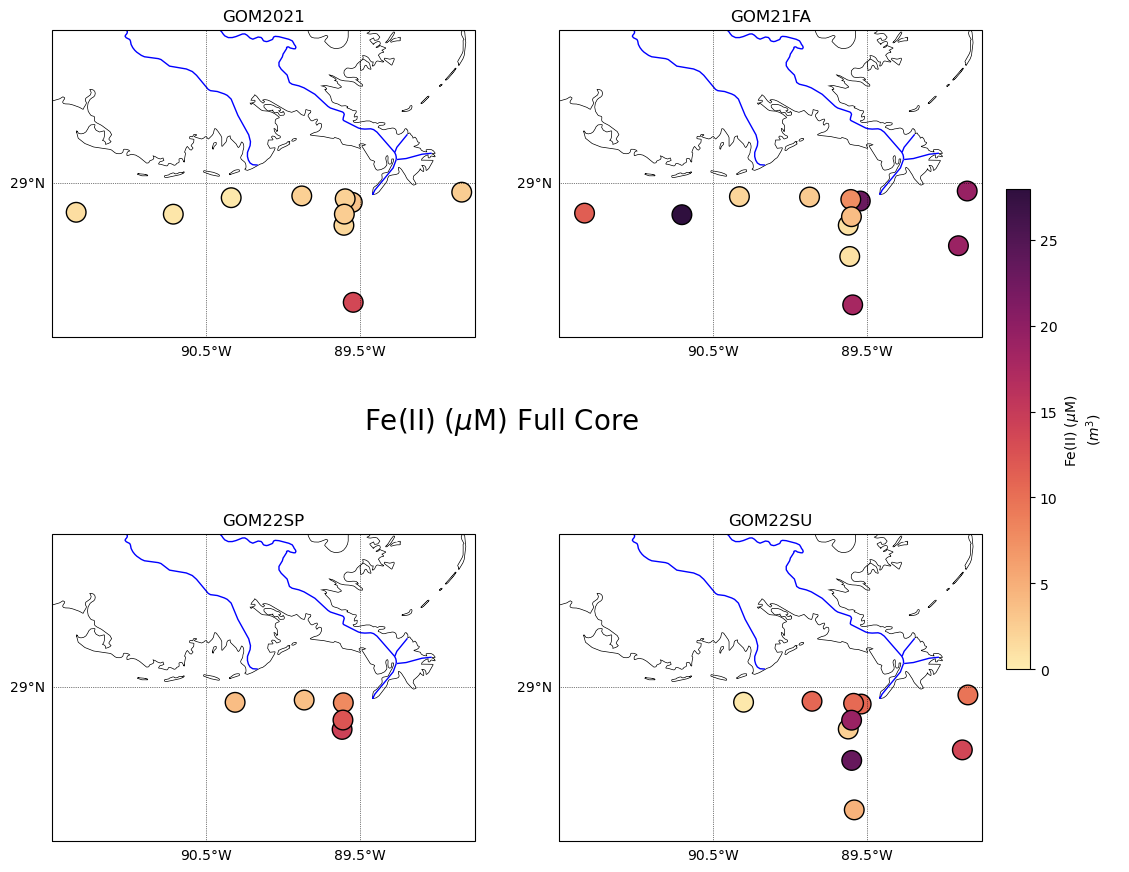

In [26]:
#set params 
vmin = 0
vmax = map_data['Fe2/m3'].max()
topic = "Fe2/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Map_Fe2_stocks.png"
cb_name = r'Fe(II) ($\mu$M) '+'\n'+r'$(m^{3})$'+'\n'
text_fig = r'Fe(II) ($\mu$M) Full Core'


plot_fe_stocks(map_data, cmo.matter)

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\2306357002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


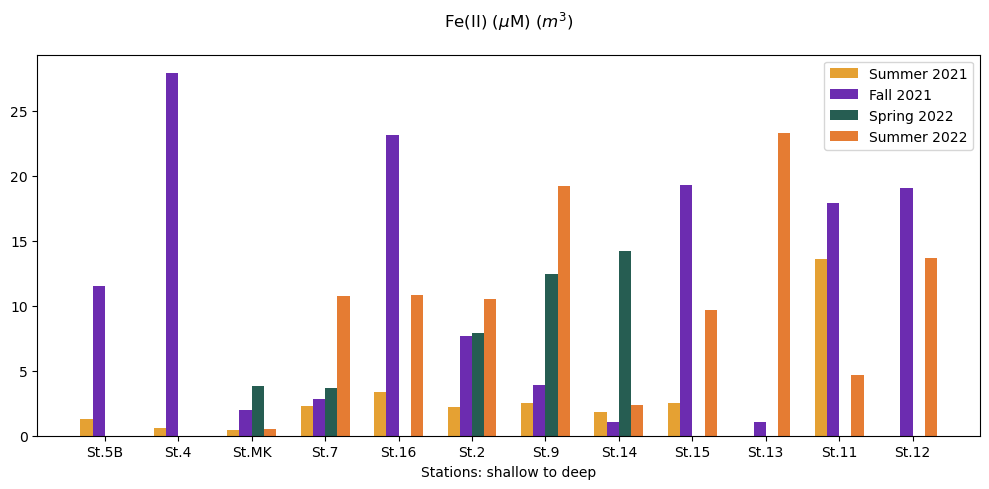

In [27]:
topic = "Fe2/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Bar_Fe2_stocks.png"
title = r'Fe(II) ($\mu$M) '+r'$(m^{3})$'+'\n'
bar_plot(map_data)

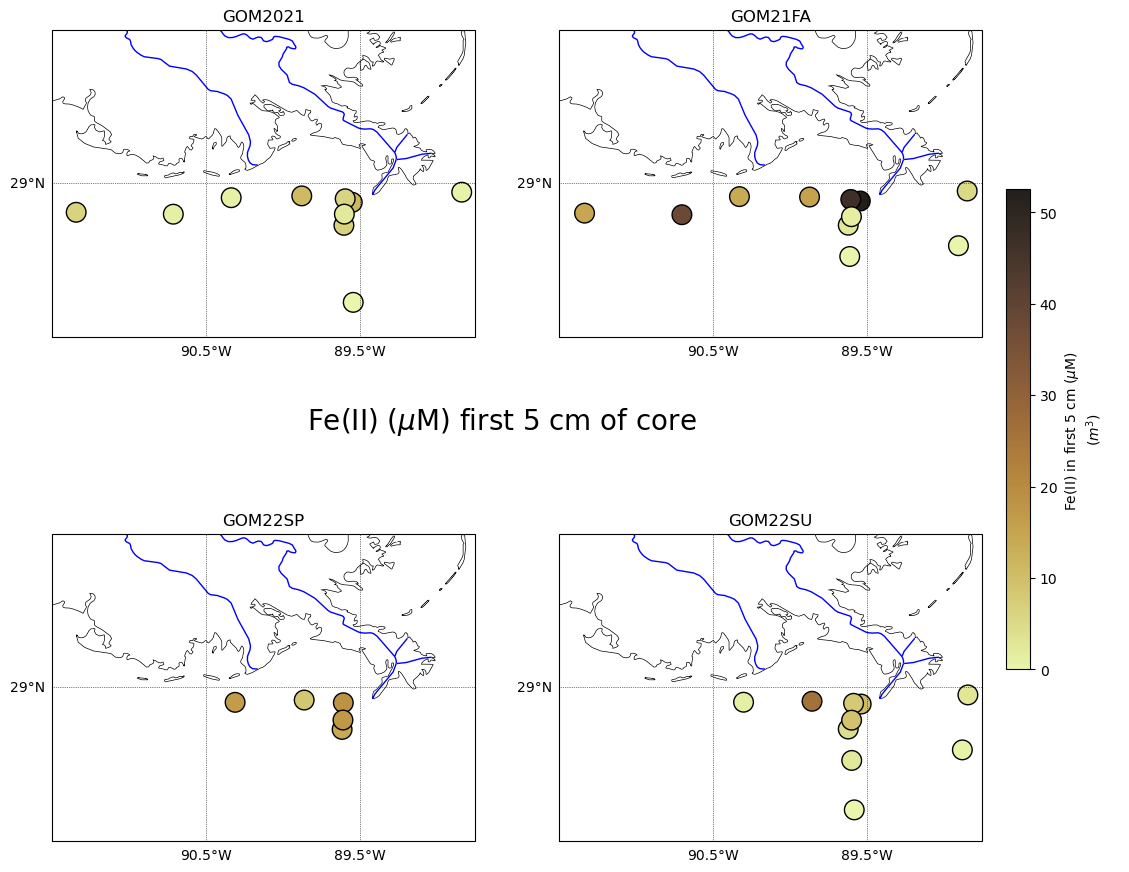

In [28]:
#set params 
vmin = 0
vmax = map_data_5cm['Fe2/m3'].max()
topic = "Fe2/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Map_Fe2_stocks_5cm.png"
cb_name = r'Fe(II) in first 5 cm ($\mu$M) '+'\n'+r'$(m^{3})$'+'\n'
text_fig = r'Fe(II) ($\mu$M) first 5 cm of core'

plot_fe_stocks(map_data_5cm, cmo.turbid)

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\2306357002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


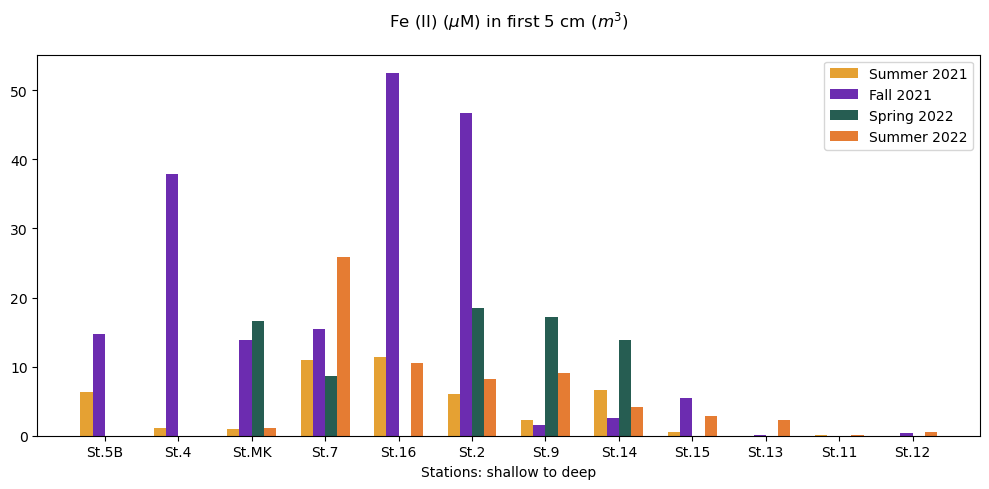

In [29]:
topic = "Fe2/m3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Bar_Fe2_stocks_5cm.png"
title = r'Fe (II) ($\mu$M) in first 5 cm '+r'$(m^{3})$'+'\n'
bar_plot(map_data_5cm)

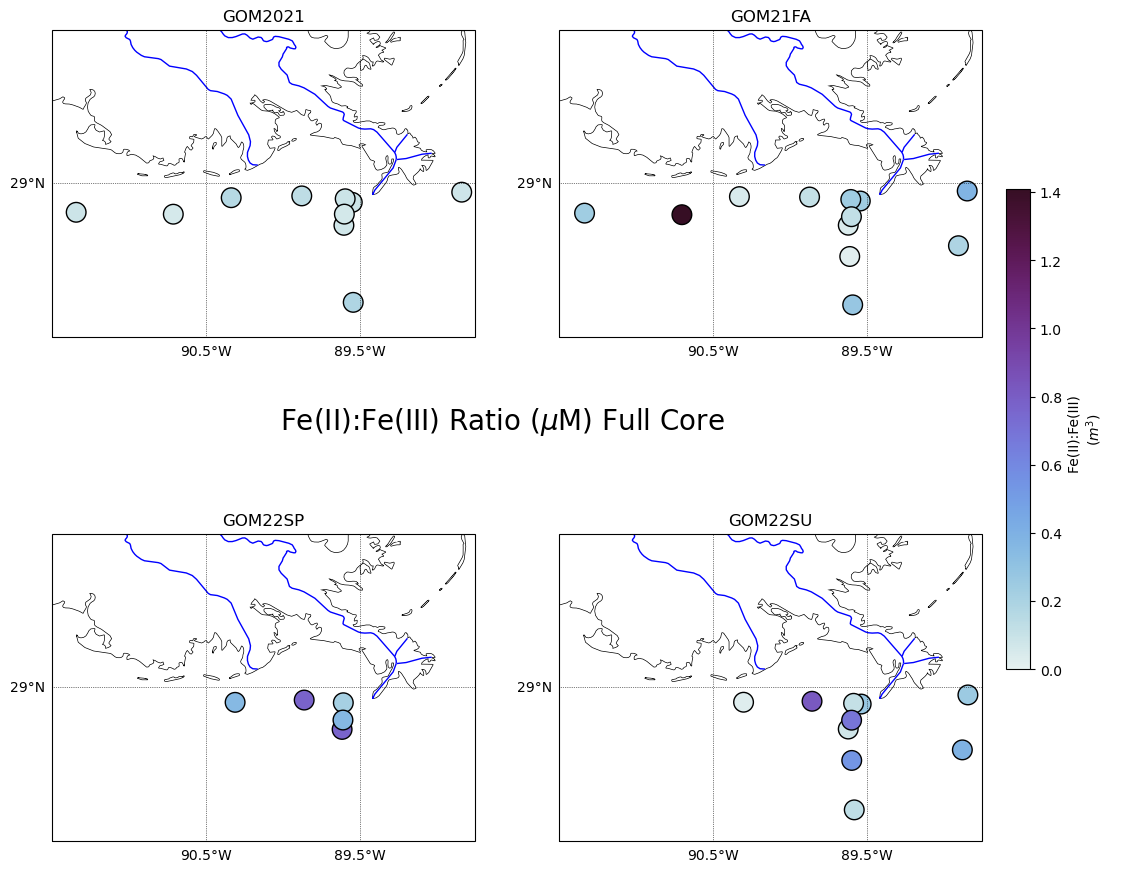

In [30]:
#set params 
vmin = 0
vmax = map_data['Fe2:Fe3'].max()
topic = "Fe2:Fe3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Map_Fe2_Fe3_ratio_stocks.png"
cb_name = r'Fe(II):Fe(III)  '+'\n'+r'$(m^{3})$'+'\n'
text_fig = r'Fe(II):Fe(III) Ratio ($\mu$M) Full Core'


plot_fe_stocks(map_data, cmo.dense)


C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\2306357002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


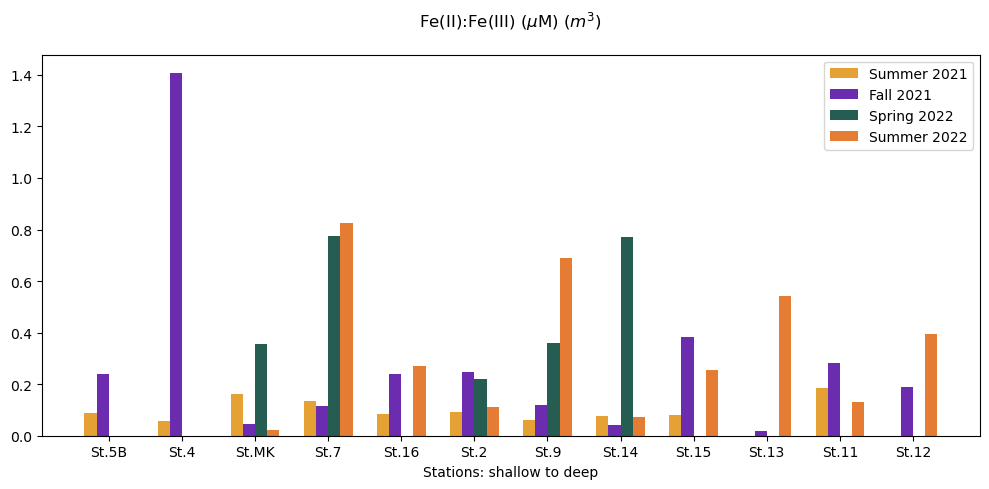

In [31]:
topic = "Fe2:Fe3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Bar_Fe2_Fe3_ratio_stocks.png"
title = r'Fe(II):Fe(III) ($\mu$M) '+r'$(m^{3})$'+'\n'
bar_plot(map_data)

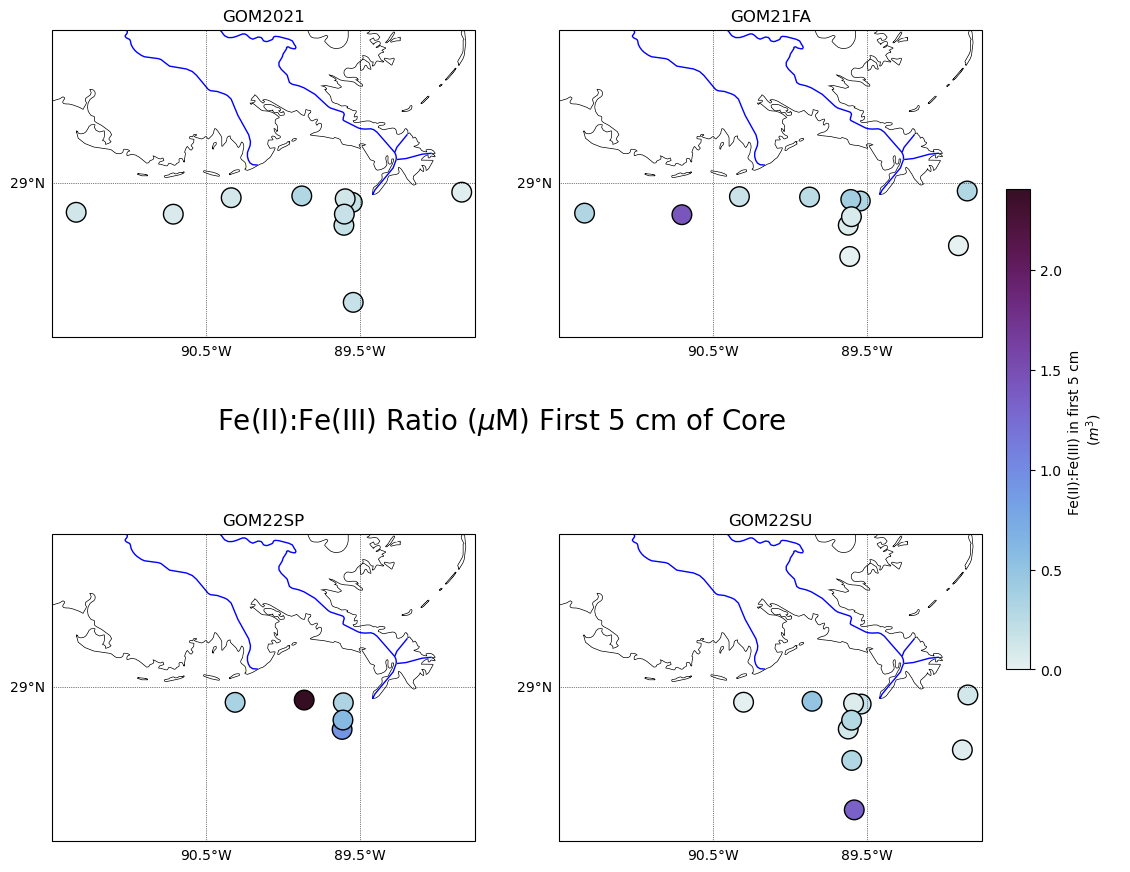

In [32]:
#set params 
vmin = 0
vmax = map_data_5cm['Fe2:Fe3'].max()
topic = "Fe2:Fe3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Map_Fe2_Fe3_ratio_stocks_5cm.png"
cb_name = r'Fe(II):Fe(III) in first 5 cm '+'\n'+r'$(m^{3})$'+'\n'
text_fig = r'Fe(II):Fe(III) Ratio ($\mu$M) First 5 cm of Core'


plot_fe_stocks(map_data_5cm, cmo.dense)

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\2306357002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


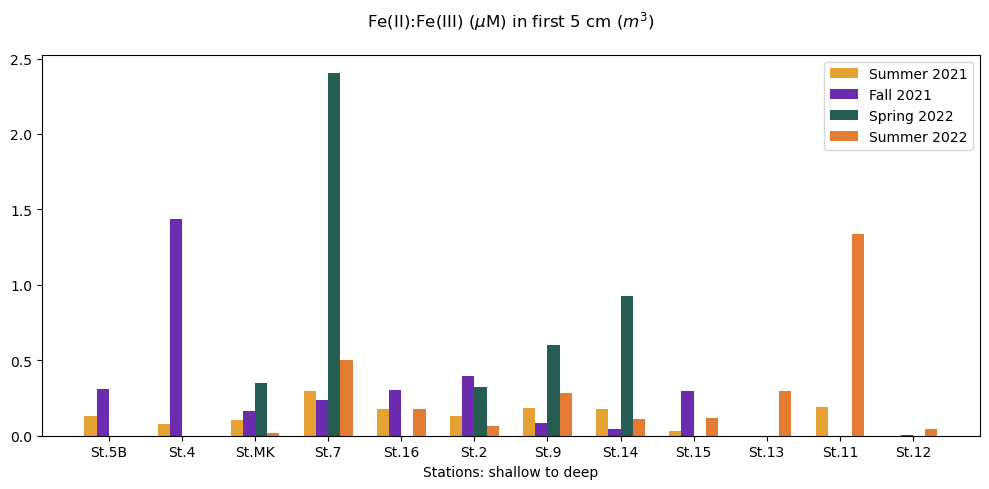

In [33]:
topic = "Fe2:Fe3"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Bar_Fe2_Fe3_ratio_stocks_5cm.png"
title = r'Fe(II):Fe(III) ($\mu$M) in first 5 cm '+r'$(m^{3})$'+'\n'
bar_plot(map_data_5cm)

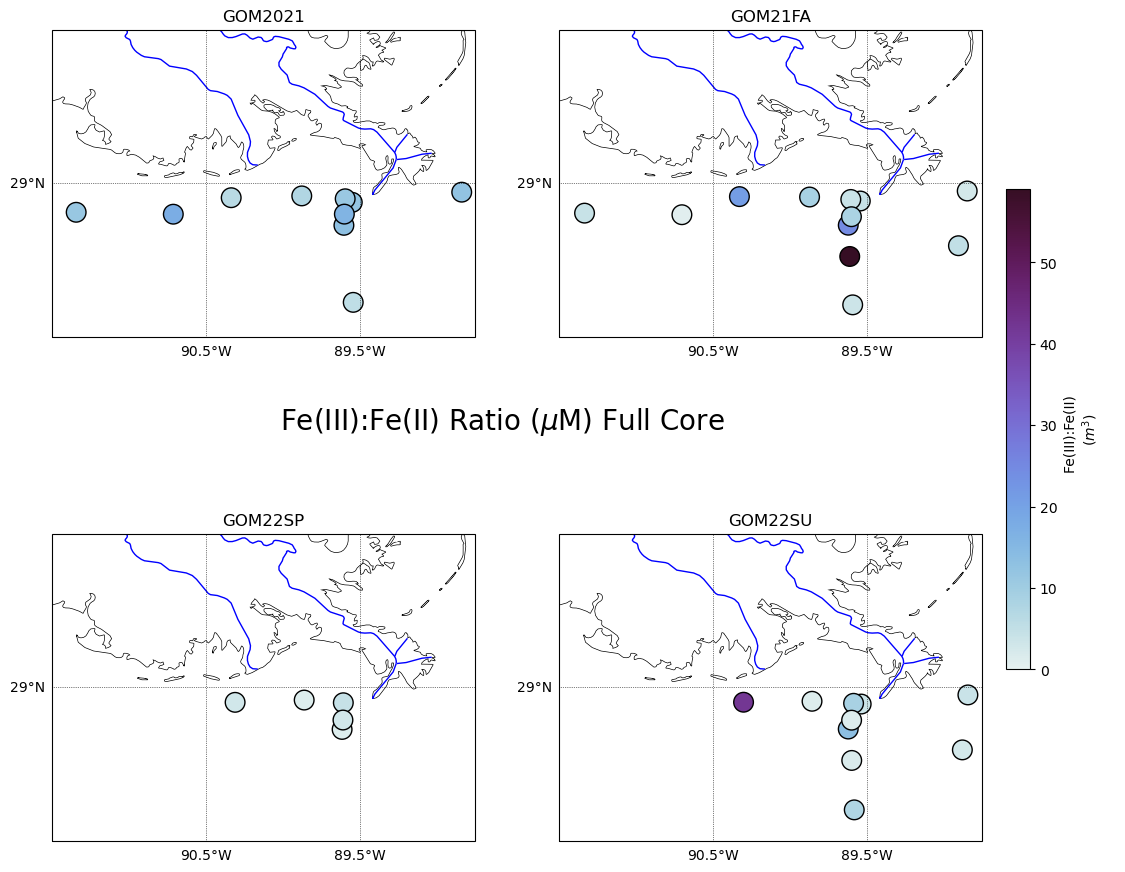

In [34]:
#set params 
vmin = 0
vmax = map_data['Fe3:Fe2'].max()
topic = "Fe3:Fe2"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Map_Fe3_Fe2_ratio_stocks.png"
cb_name = r'Fe(III):Fe(II)  '+'\n'+r'$(m^{3})$'+'\n'
text_fig = r'Fe(III):Fe(II) Ratio ($\mu$M) Full Core'

plot_fe_stocks(map_data, cmo.dense)


C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\2306357002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


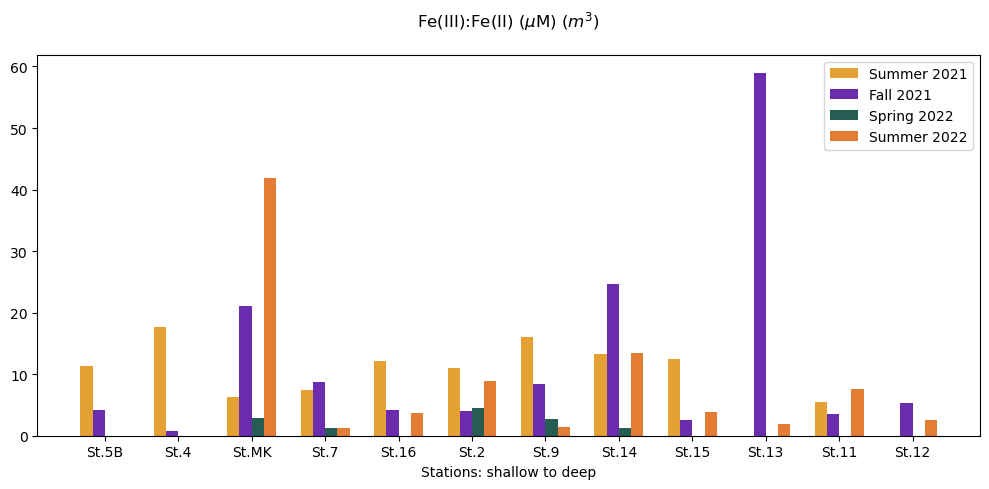

In [35]:
topic = "Fe3:Fe2"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Bar_Fe3_Fe2_ratio_stocks.png"
title = r'Fe(III):Fe(II) ($\mu$M) '+r'$(m^{3})$'+'\n'
bar_plot(map_data)

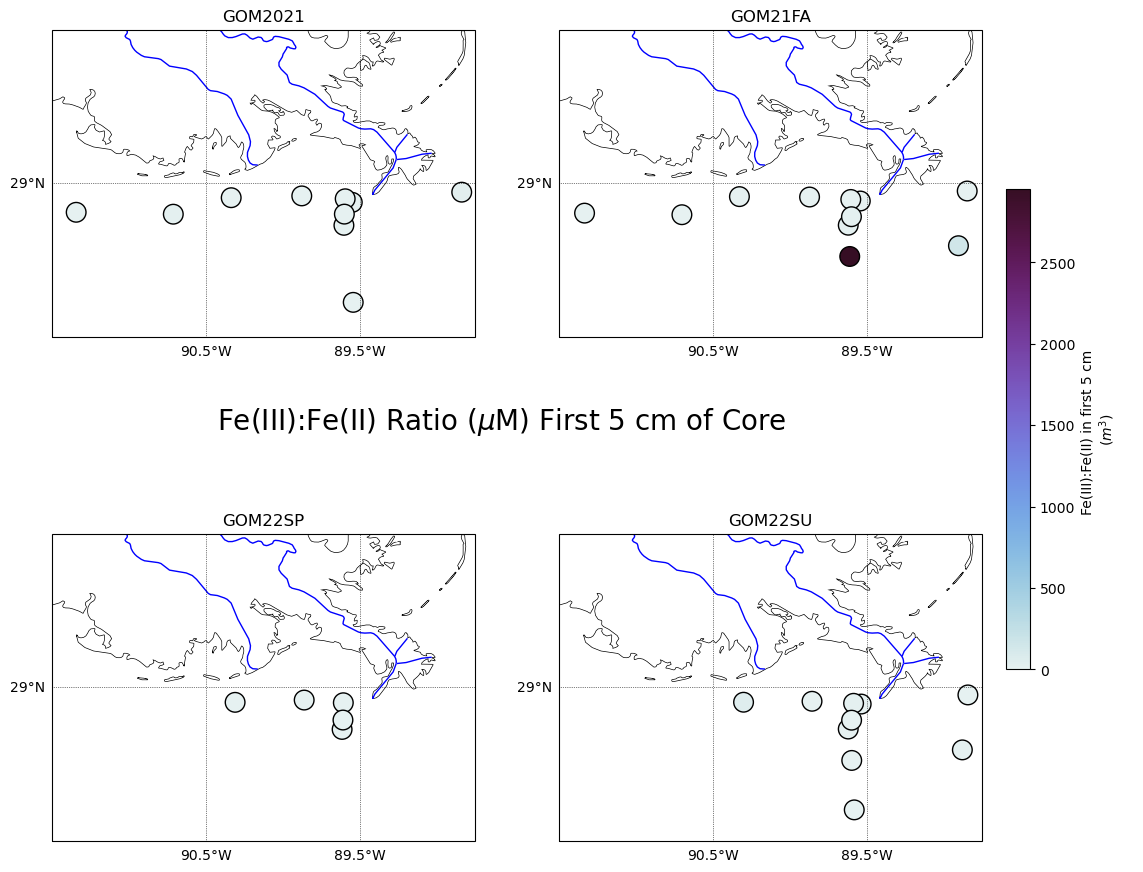

In [36]:
#set params 
vmin = 0
vmax = map_data_5cm['Fe3:Fe2'].max()
topic = "Fe3:Fe2"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Map_Fe3_Fe2_ratio_stocks_5cm.png"
cb_name = r'Fe(III):Fe(II) in first 5 cm '+'\n'+r'$(m^{3})$'+'\n'
text_fig = r'Fe(III):Fe(II) Ratio ($\mu$M) First 5 cm of Core'

plot_fe_stocks(map_data_5cm, cmo.dense)

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9800\2306357002.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


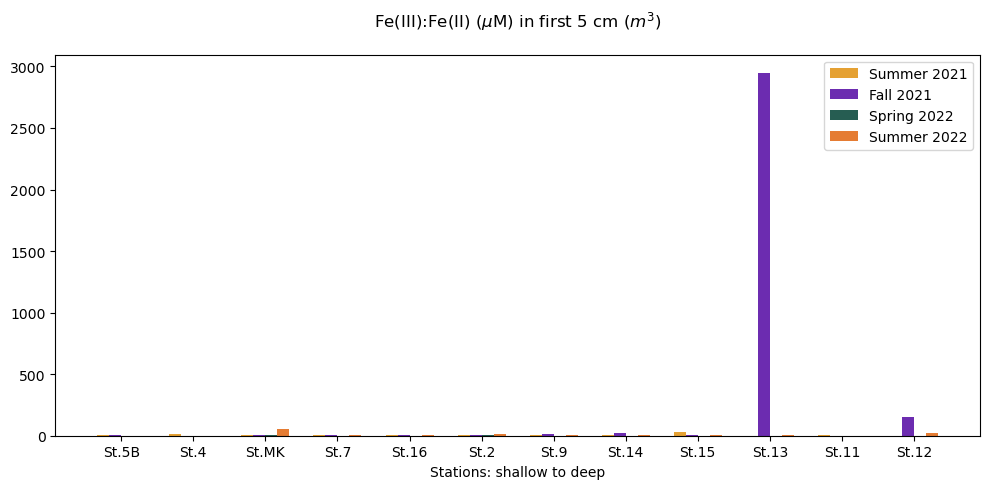

In [37]:
topic = "Fe3:Fe2"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Bar_Fe3_Fe2_ratio_stocks_5cm.png"
title = r'Fe(III):Fe(II) ($\mu$M) in first 5 cm '+r'$(m^{3})$'+'\n'
bar_plot(map_data_5cm)

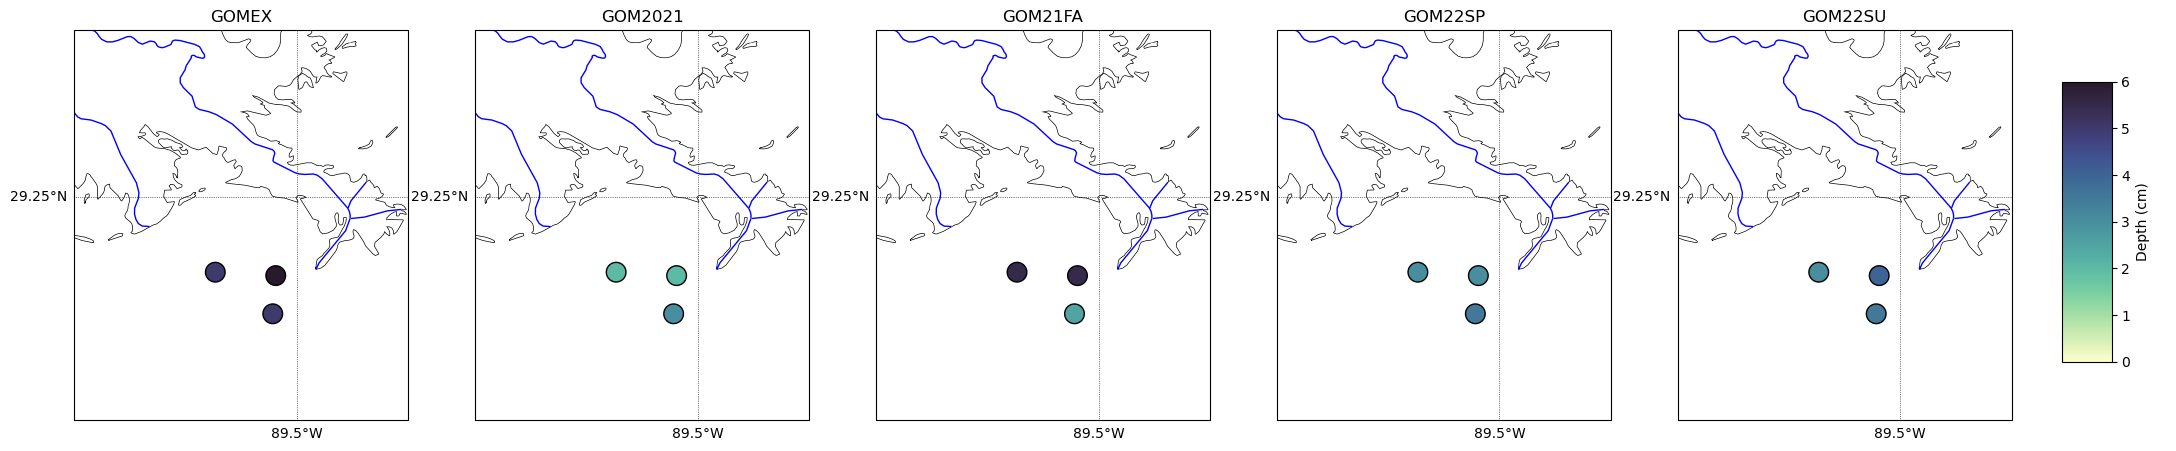

In [38]:
lat_top=30
lat_bot=28.25
lon_left=-90.5
lon_rigth=-89
extent_2=[lon_left, lon_rigth, lat_bot, lat_top]

# List of unique Camp values you want to plot
camps = ['GOMEX','GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

#set params 
vmin = 0
vmax = 6
topic = "mm_depth_cm"
plot_save = "../Dissertation_projects/Figures/Stock_figures/Map_mobile_mud.png"
cb_name = r'Depth (cm)'+'\n'

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 7), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index

for i, camp in enumerate(camps):
    df_subset = df_mobile_mud[df_mobile_mud['camp'] == camp].dropna(subset=[topic])    
    
    # Plot the base map for each subplot
    plot_mapbase(extent_2, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['Lon'], df_subset['Lat'],
                               c=df_subset[topic],
                               edgecolor='k',
                               cmap=cmo.deep,
                               s=200,
                               vmin=vmin,  # Set global min and max for colormap
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label(cb_name, size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

fig.set_facecolor('w')

plt.savefig(plot_save)

plt.show()

In [39]:
stop 

NameError: name 'stop' is not defined

In [ ]:
#issues with the RHZ ones 
mask = (df_iron_rz["Fe2_Depth"] != df_iron_rz["FeT_Depth"]) & (~df_iron_rz["Fe2_Depth"].isna()) & (~df_iron_rz["FeT_Depth"].isna())

# Use the mask to filter rows
mismatched_rows = df_iron_rz[mask]

# Print the resulting DataF
mismatched_rows
